In [1]:
%matplotlib inline
import numpy as np # imports a fast numerical programming library
import scipy as sp # imports a statistical programming library
import matplotlib as mpl # imports the standard plotting library
import matplotlib.cm as cm # imports plotting colormaps
import matplotlib.pyplot as plt # imports the MATLAB compatible plotting API
import pandas as pd # imports a library to handle data as dataframes
import seaborn.apionly as sns

/opt/conda/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/conda/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/conda/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [43]:
import wandb
from wandb.keras import WandbCallback
run = wandb.init()

W&B Run: https://app.wandb.ai/univai-ss2019/HackRecos/runs/i0vvz7x2
Call `%%wandb` in the cell containing your training loop to display live results.


In [3]:
df = pd.read_csv("ratings.csv.gz", compression='gzip')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
df.drop("timestamp",inplace=True, axis=1)
df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [5]:
df.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [47]:
df2 = df.sample(500000)

In [48]:
df2.userId = df2.userId.astype('category').cat.codes.values
df2.movieId = df2.movieId.astype('category').cat.codes.values

In [49]:
n_ratings = df2.shape[0]
n_ratings

500000

In [50]:
n_factors=3
n_users, n_movies = len(df2.userId.unique()), len(df2.movieId.unique())
n_users, n_movies

(107014, 13147)

In [10]:
df2.head()

,userId,movieId,rating
16724527,27904,941,3.0
6211895,10252,395,2.5
18570244,31047,6415,4.0
44365,74,3378,2.0
18513152,30961,788,2.5


In [51]:
np.random.seed=2017
mask = np.random.rand(500000) < 0.8

In [53]:
traindf = df2[mask]
testdf = df2[~mask]

In [61]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

movie_input = keras.layers.Input(shape=[1],name='movieId')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_factors, name='movieEmbedding')(movie_input)
movie_embedding_droput = keras.layers.Dropout(0.2)(movie_embedding) 
movie_vec = keras.layers.Flatten(name='movieFlatten')(movie_embedding_droput)

user_input = keras.layers.Input(shape=[1],name='userId')
user_embedding = keras.layers.Embedding(n_users + 1, n_factors,name='userEmbedding')(user_input)
user_embedding_dropout = keras.layers.Dropout(0.2)(user_embedding)
user_vec = keras.layers.Flatten(name='userFlatten')(user_embedding_dropout)

prod = keras.layers.Dot(axes=1, name="MatrixFactorization")([movie_vec, user_vec] )
act = keras.layers.Activation('hard_sigmoid')(prod)
fin_prod = keras.layers.Lambda(lambda x: 5*x + 0.5)(act)
model = keras.Model([user_input, movie_input], fin_prod)
model.compile('adam', 'mse')

In [20]:
movie_input

<tf.Tensor 'movieId:0' shape=(?, 1) dtype=float32>

In [62]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movieId (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
userId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
movieEmbedding (Embedding)      (None, 1, 3)         39444       movieId[0][0]                    
__________________________________________________________________________________________________
userEmbedding (Embedding)       (None, 1, 3)         321045      userId[0][0]                     
__________________________________________________________________________________________________
dropout_9 

In [24]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
# SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [33]:
traindf.userId.values

array([10252,    74, 28423, ..., 18312,  2874,  1637], dtype=int32)

In [63]:
history = model.fit([traindf.userId.values, traindf.movieId.values], traindf.rating.values, epochs=70, batch_size = 512, callbacks=[WandbCallback()])

Epoch 1/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.3862
Epoch 2/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.3829
Epoch 3/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.3681
Epoch 4/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.3343
Epoch 5/70
399970/399970 [==============================] - 4s 10us/step - loss: 1.2840
Epoch 6/70
399970/399970 [==============================] - 4s 10us/step - loss: 1.2258
Epoch 7/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.1685
Epoch 8/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.1166
Epoch 9/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.0700
Epoch 10/70
399970/399970 [==============================] - 4s 10us/step - loss: 1.0318
Epoch 11/70
399970/399970 [==============================] - 4s 11us/step - loss: 1.0005
Epoch 12/70
399970/399970 [===

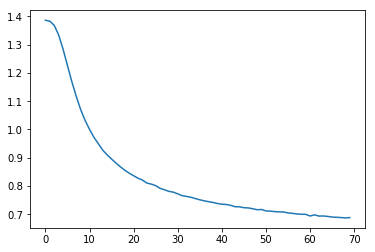

In [64]:
plt.plot(history.history['loss'])

In [65]:
y_hat = model.predict([testdf.userId.values, testdf.movieId.values])
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(testdf.rating.values, y_hat))

1.1572653348510846